# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from time import time

from graph_based_planner import GraphBasedPlanner

%matplotlib inline

Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


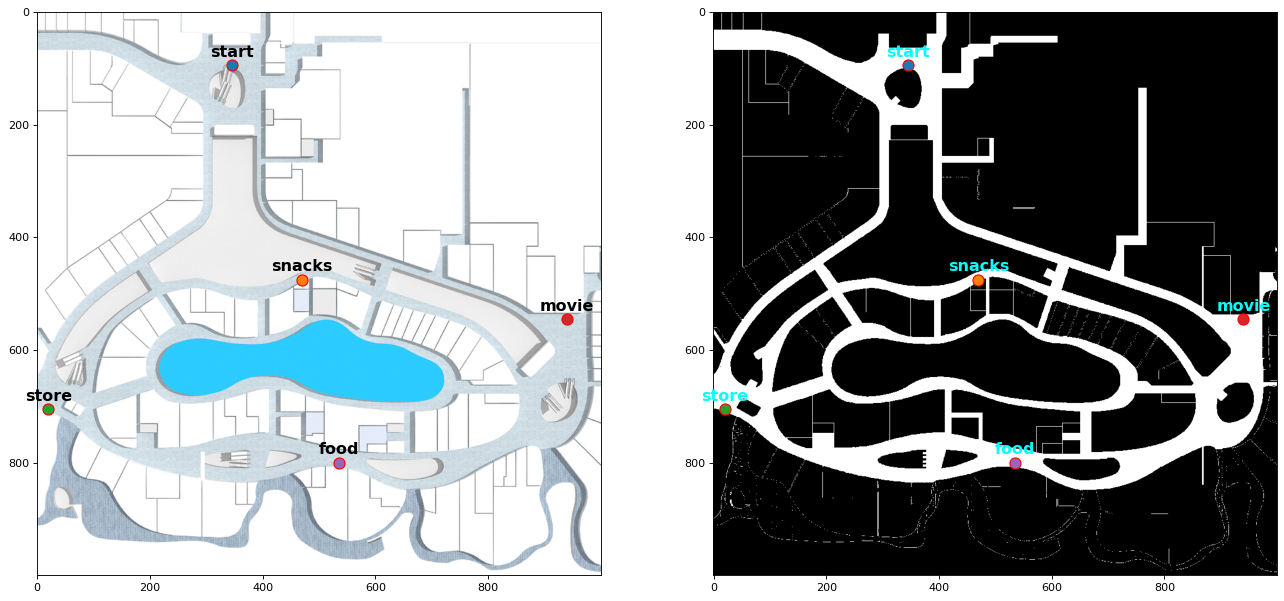

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [2]:
# Load the map
floor_plan = cv2.imread('./map/vivocity.png')
grid_map_img = cv2.imread('./map/vivocity_freespace.png', cv2.IMREAD_GRAYSCALE)
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# agent radius which in this case is the human footprint
AGENT_RADIUS = 0.3

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1

In [3]:
def plot_path(path, colour, legend):
    plt.imshow(grid_map_img, cmap='gray')
    plot_locations(locations, color='cyan')
    x, y = zip(*path)
    plt.plot(x, y, linewidth=2.0, color=colour, label=legend)


def print_result_summary(data, location_names):
    data_text = list(map(lambda row: list(map(lambda entry: f'{entry:.2f}' if isinstance(entry, float) else str(entry), row)), data))
    data_text.insert(0, location_names)
    data_text = list(zip(*data_text))
    data_text.insert(0, location_names)
    data_text[0].insert(0, 'To\From')
    data_text = list(zip(*data_text))
    column_width = list(map(lambda col: max(map(lambda entry: len(entry), col)), zip(*data_text)))
    for row in range(len(data_text)):
        for col in range(len(data_text[row])):
            width = column_width[col]
            print(f'|{data_text[row][col]:<{width}}', end='')

        print('|')

    print('\n')


def runner(planner):
    path_colours = ('red', 'blue', 'green', 'yellow', 'violet')

    num_loc = len(locations)
    # Result table
    ## distance
    distance_table = [[0. for _ in range(num_loc)] for _ in range(num_loc)]

    ## time cost
    time_cost_table = [[0. for _ in range(num_loc)] for _ in range(num_loc)]

    ## number of visited grid
    n_visited_table = [[0 for _ in range(num_loc)] for _ in range(num_loc)]

    for i, (start_loc_name, start_pos) in enumerate(locations.items()):
        plt.figure(figsize=(10, 10))
        for j, (dest_loc_name, dest_pos) in enumerate(locations.items()):
            if start_loc_name != dest_loc_name:
                start_time = time()
                result = planner.plan(start_pos, dest_pos)
                time_cost = time() - start_time
                if result is not None:
                    path, distance, visited_grids = result
                    distance_table[j][i] = distance
                    time_cost_table[j][i] = time_cost
                    n_visited_table[j][i] = len(visited_grids)
                    plot_path(path, path_colours[j], f'{start_loc_name} to {dest_loc_name} (distance={distance:.2f}m, time={time_cost:.2f}s, visited grid={len(visited_grids)})')

        plt.legend()
        plt.show()

    print_result_summary(distance_table, list(locations.keys()))
    print_result_summary(time_cost_table, list(locations.keys()))
    print_result_summary(n_visited_table, list(locations.keys()))


In [4]:
# Heuristic functions

euclidean = lambda curr_pos, goal: MAP_RES * np.linalg.norm(np.array(curr_pos) - np.array(goal))
chebyshev = lambda curr_pos, goal: MAP_RES * np.max(np.abs(np.array(curr_pos) - np.array(goal)))
manhattan = lambda curr_pos, goal: MAP_RES * np.sum(np.abs(np.array(curr_pos) - np.array(goal)))


Running A* planner with Euclidean heuristic function...


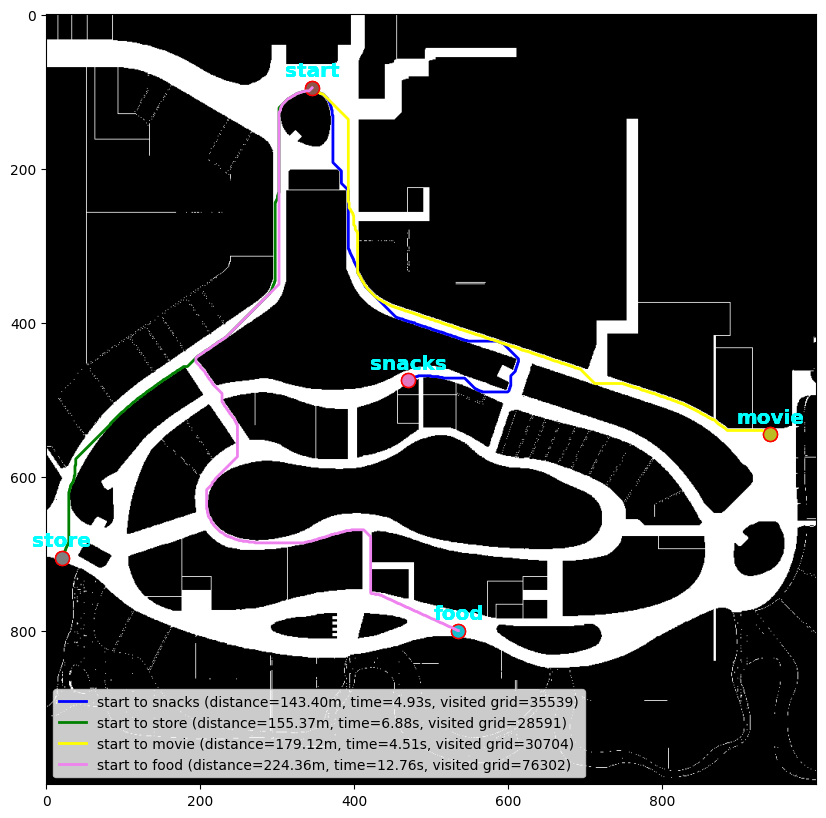

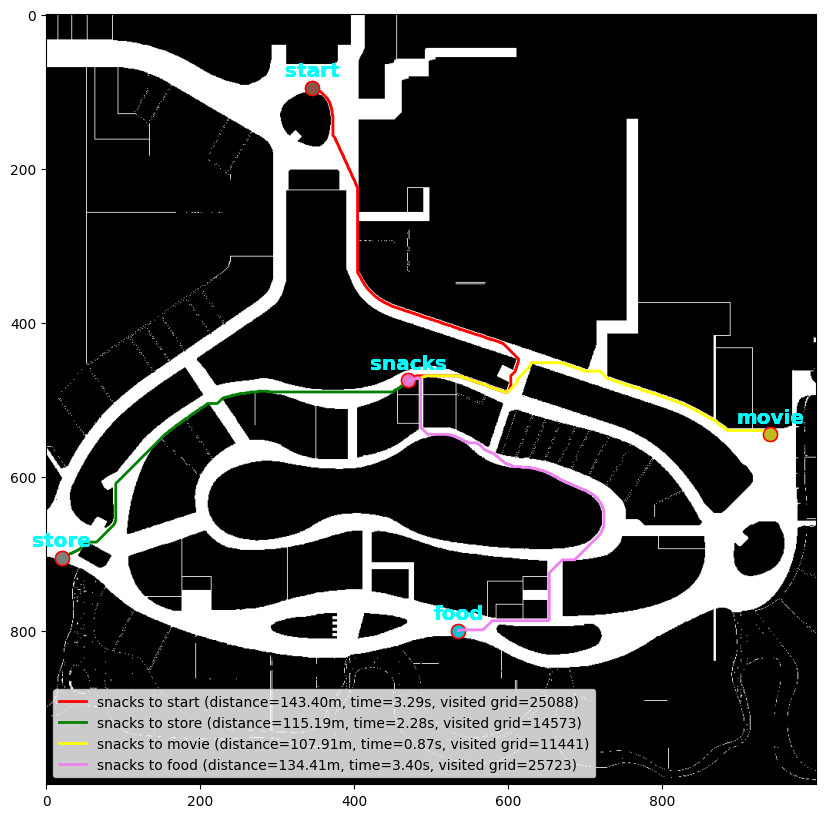

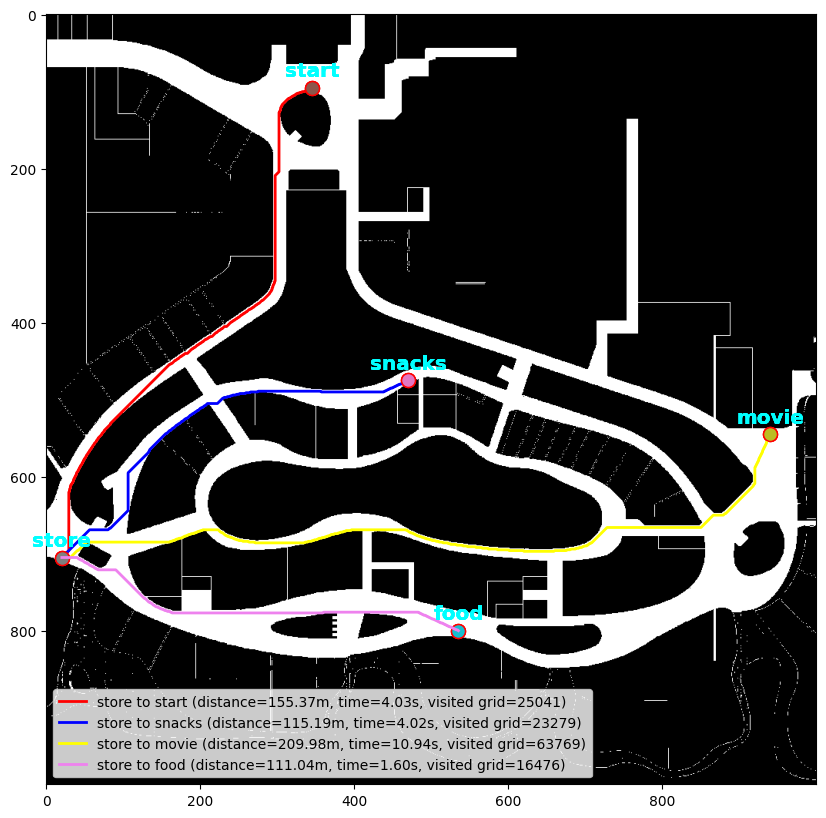

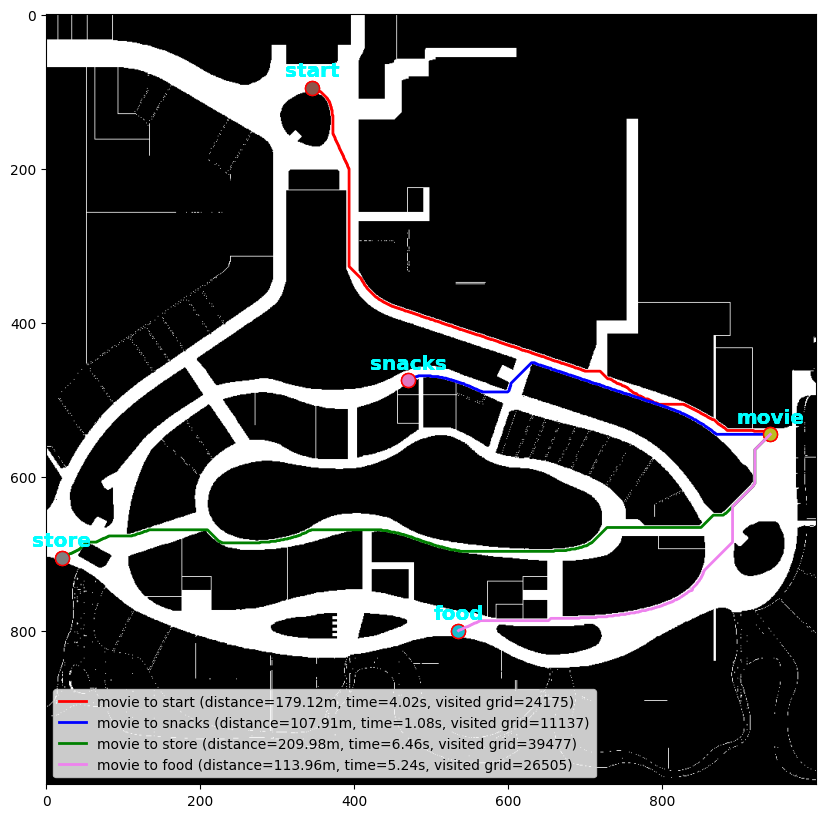

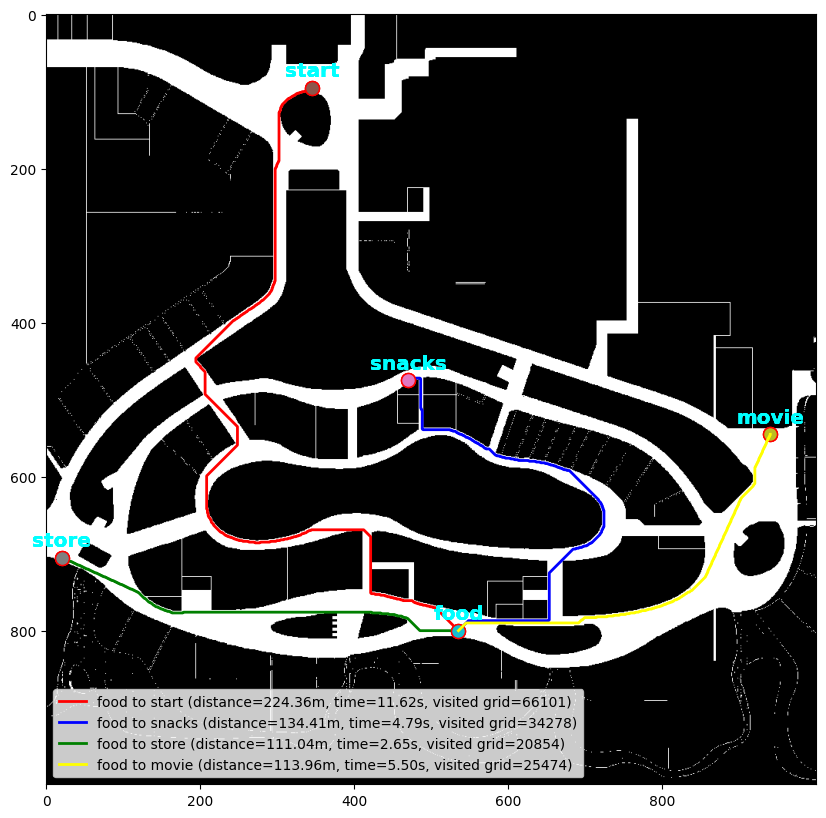

|To\From|start |snacks|store |movie |food  |
|start  |0.00  |143.40|155.37|179.12|224.36|
|snacks |143.40|0.00  |115.19|107.91|134.41|
|store  |155.37|115.19|0.00  |209.98|111.04|
|movie  |179.12|107.91|209.98|0.00  |113.96|
|food   |224.36|134.41|111.04|113.96|0.00  |


|To\From|start|snacks|store|movie|food |
|start  |0.00 |3.29  |4.03 |4.02 |11.62|
|snacks |4.93 |0.00  |4.02 |1.08 |4.79 |
|store  |6.88 |2.28  |0.00 |6.46 |2.65 |
|movie  |4.51 |0.87  |10.94|0.00 |5.50 |
|food   |12.76|3.40  |1.60 |5.24 |0.00 |


|To\From|start|snacks|store|movie|food |
|start  |0    |25088 |25041|24175|66101|
|snacks |35539|0     |23279|11137|34278|
|store  |28591|14573 |0    |39477|20854|
|movie  |30704|11441 |63769|0    |25474|
|food   |76302|25723 |16476|26505|0    |




In [5]:
# A* planner (Euclidean heuristic)

astar_planner = GraphBasedPlanner(grid_map_img, MAP_RES, AGENT_RADIUS, search_method='a*', heuristic_func=euclidean)

print('Running A* planner with Euclidean heuristic function...')
runner(astar_planner)


Running A* planner with Chebyshev heuristic function...


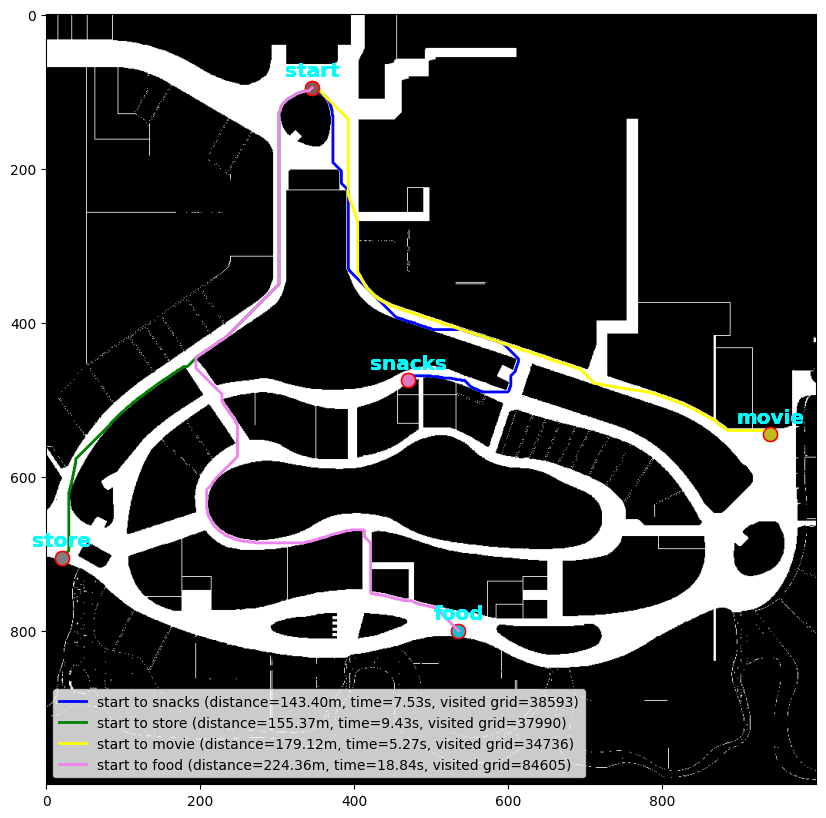

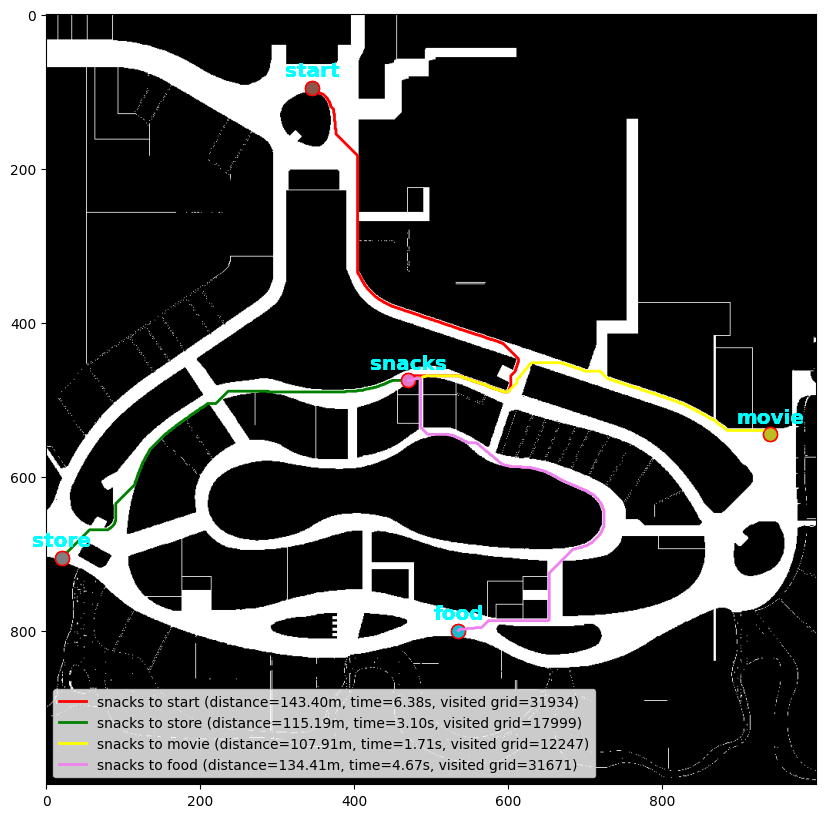

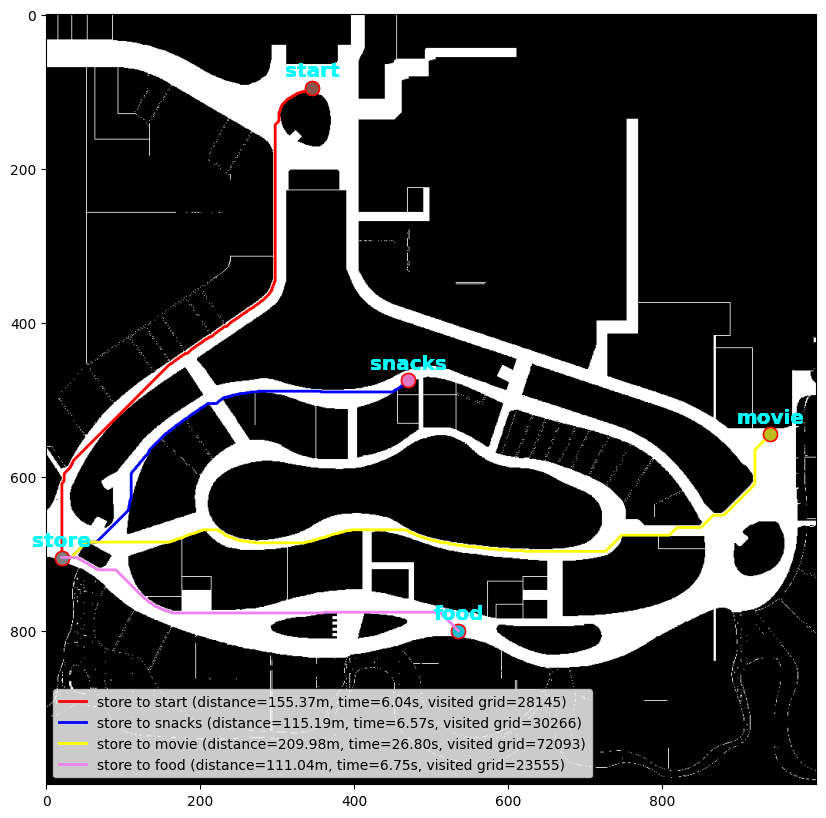

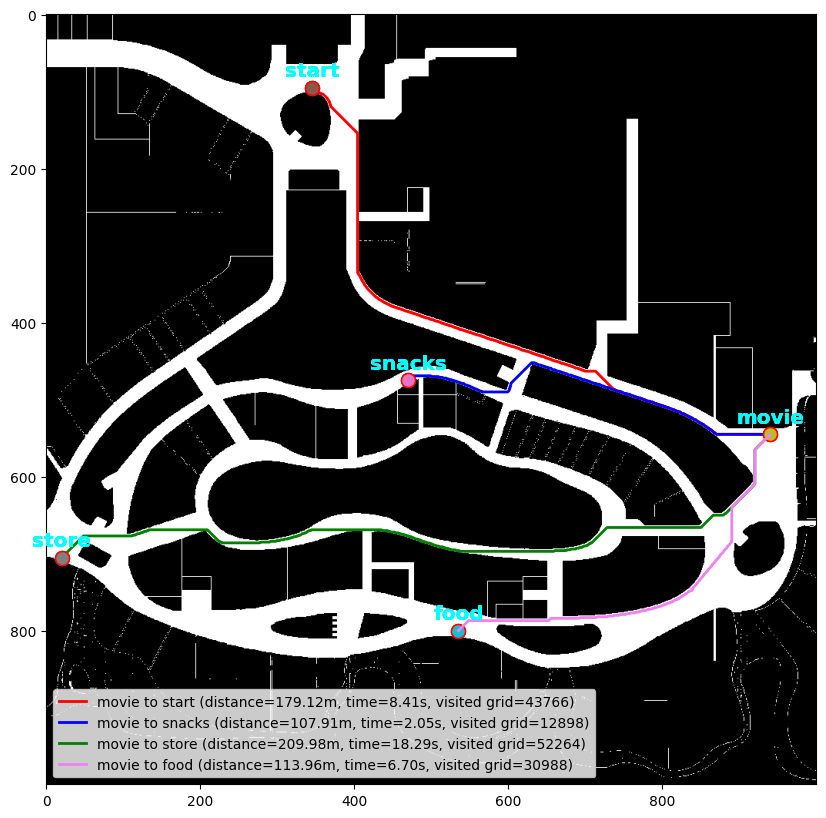

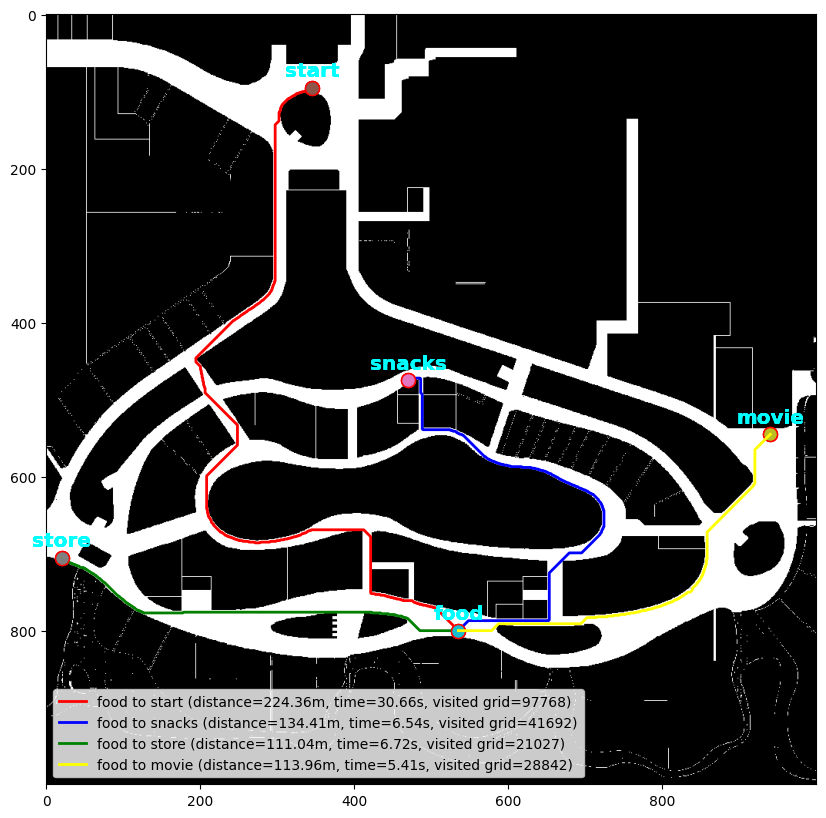

|To\From|start |snacks|store |movie |food  |
|start  |0.00  |143.40|155.37|179.12|224.36|
|snacks |143.40|0.00  |115.19|107.91|134.41|
|store  |155.37|115.19|0.00  |209.98|111.04|
|movie  |179.12|107.91|209.98|0.00  |113.96|
|food   |224.36|134.41|111.04|113.96|0.00  |


|To\From|start|snacks|store|movie|food |
|start  |0.00 |6.38  |6.04 |8.41 |30.66|
|snacks |7.53 |0.00  |6.57 |2.05 |6.54 |
|store  |9.43 |3.10  |0.00 |18.29|6.72 |
|movie  |5.27 |1.71  |26.80|0.00 |5.41 |
|food   |18.84|4.67  |6.75 |6.70 |0.00 |


|To\From|start|snacks|store|movie|food |
|start  |0    |31934 |28145|43766|97768|
|snacks |38593|0     |30266|12898|41692|
|store  |37990|17999 |0    |52264|21027|
|movie  |34736|12247 |72093|0    |28842|
|food   |84605|31671 |23555|30988|0    |




In [6]:
# A* planner (Chebyshev heuristic)

astar_planner = GraphBasedPlanner(grid_map_img, MAP_RES, AGENT_RADIUS, search_method='a*', heuristic_func=chebyshev)

print('Running A* planner with Chebyshev heuristic function...')
runner(astar_planner)


Running A* planner with Manhattan heuristic function...


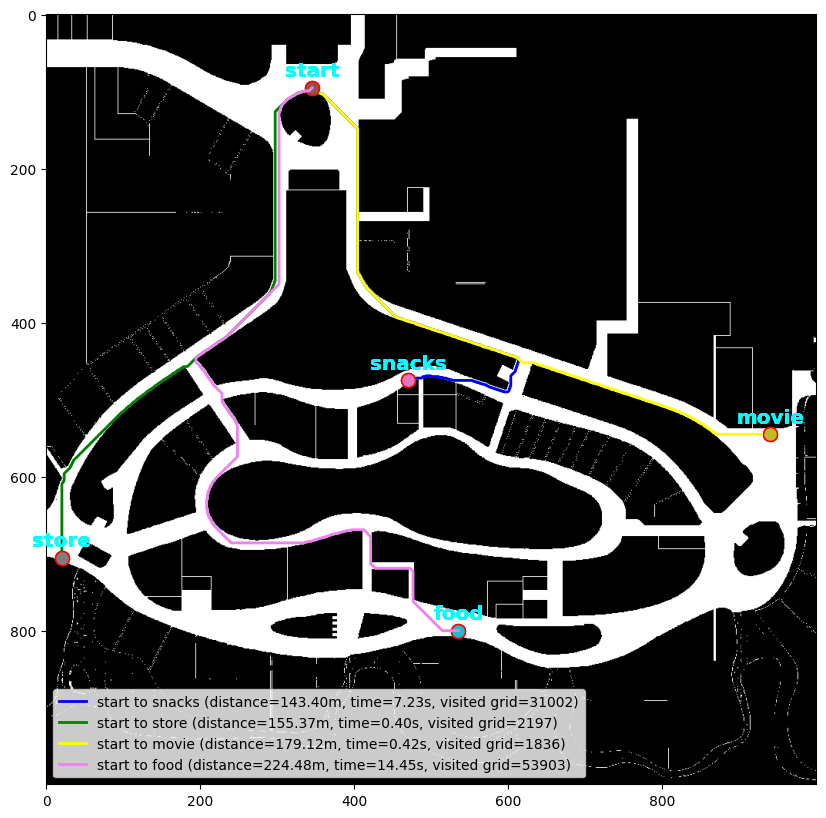

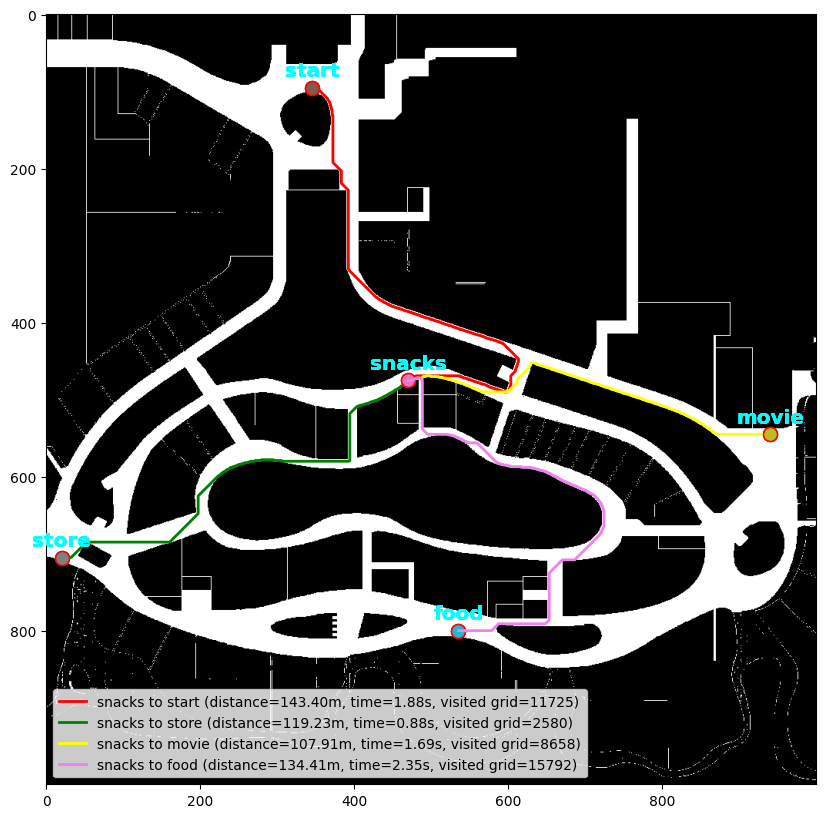

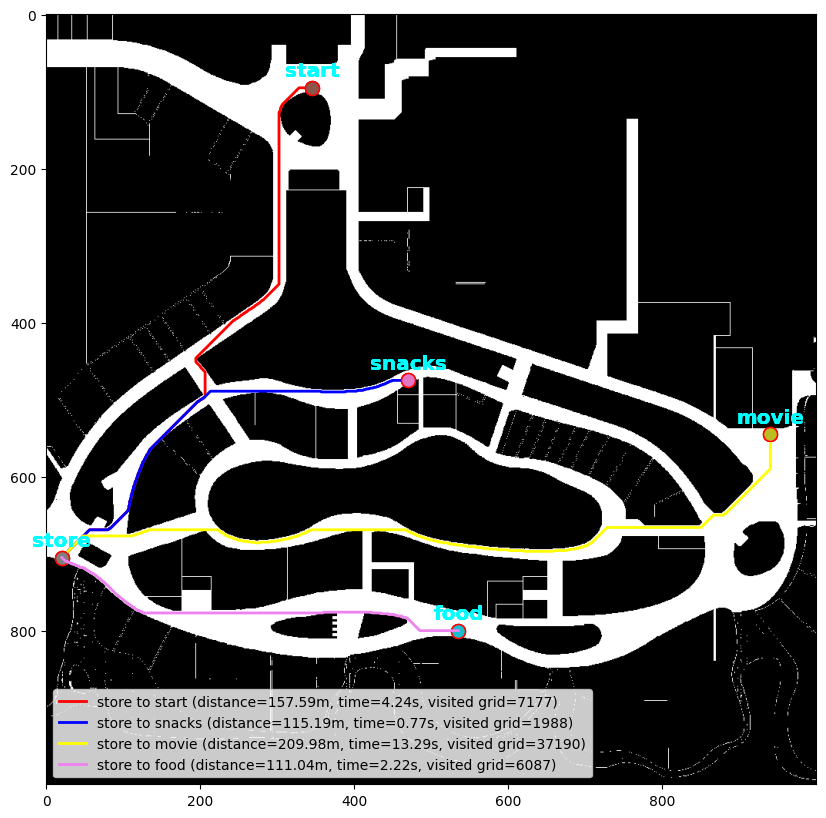

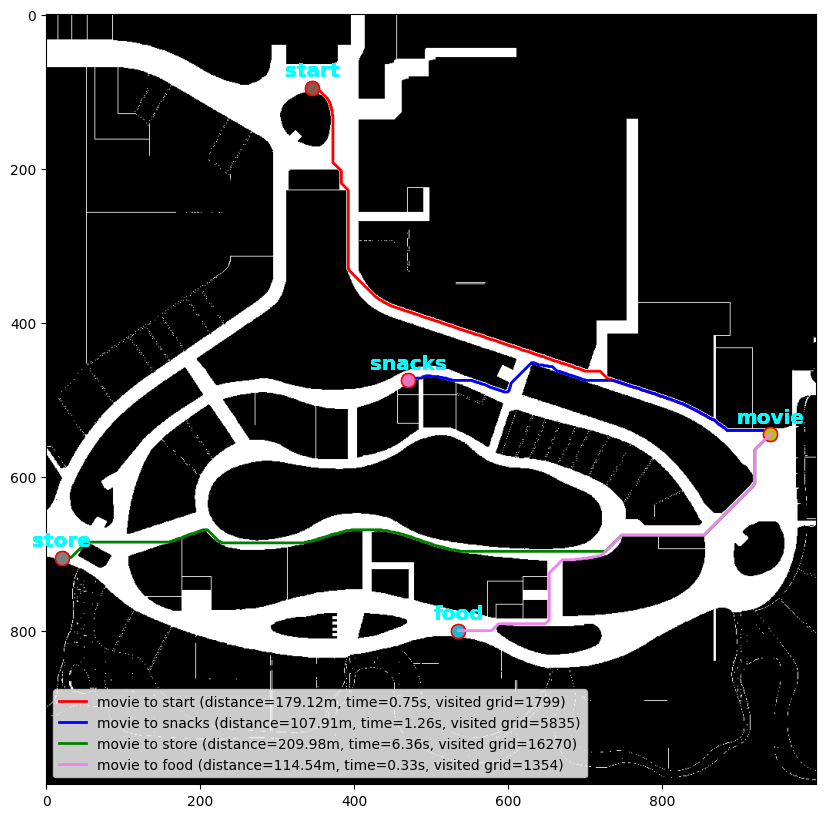

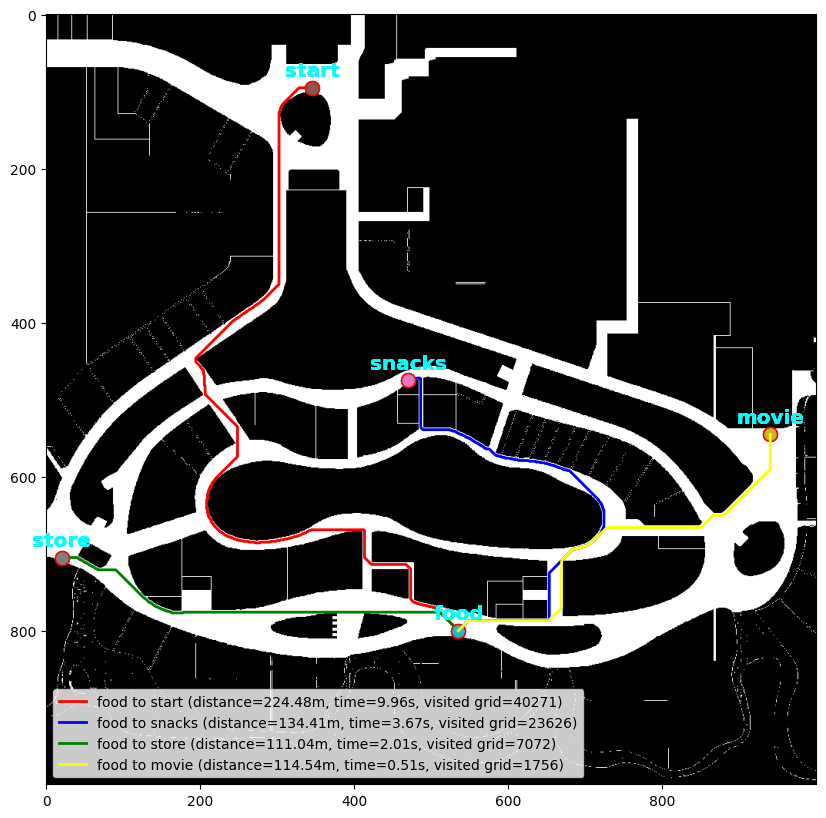

|To\From|start |snacks|store |movie |food  |
|start  |0.00  |143.40|157.59|179.12|224.48|
|snacks |143.40|0.00  |115.19|107.91|134.41|
|store  |155.37|119.23|0.00  |209.98|111.04|
|movie  |179.12|107.91|209.98|0.00  |114.54|
|food   |224.48|134.41|111.04|114.54|0.00  |


|To\From|start|snacks|store|movie|food|
|start  |0.00 |1.88  |4.24 |0.75 |9.96|
|snacks |7.23 |0.00  |0.77 |1.26 |3.67|
|store  |0.40 |0.88  |0.00 |6.36 |2.01|
|movie  |0.42 |1.69  |13.29|0.00 |0.51|
|food   |14.45|2.35  |2.22 |0.33 |0.00|


|To\From|start|snacks|store|movie|food |
|start  |0    |11725 |7177 |1799 |40271|
|snacks |31002|0     |1988 |5835 |23626|
|store  |2197 |2580  |0    |16270|7072 |
|movie  |1836 |8658  |37190|0    |1756 |
|food   |53903|15792 |6087 |1354 |0    |




In [7]:
# A* planner (Manhattan heuristic)

astar_planner = GraphBasedPlanner(grid_map_img, MAP_RES, AGENT_RADIUS, search_method='a*', heuristic_func=manhattan)

print('Running A* planner with Manhattan heuristic function...')
runner(astar_planner)


Running Dijkstra planner...


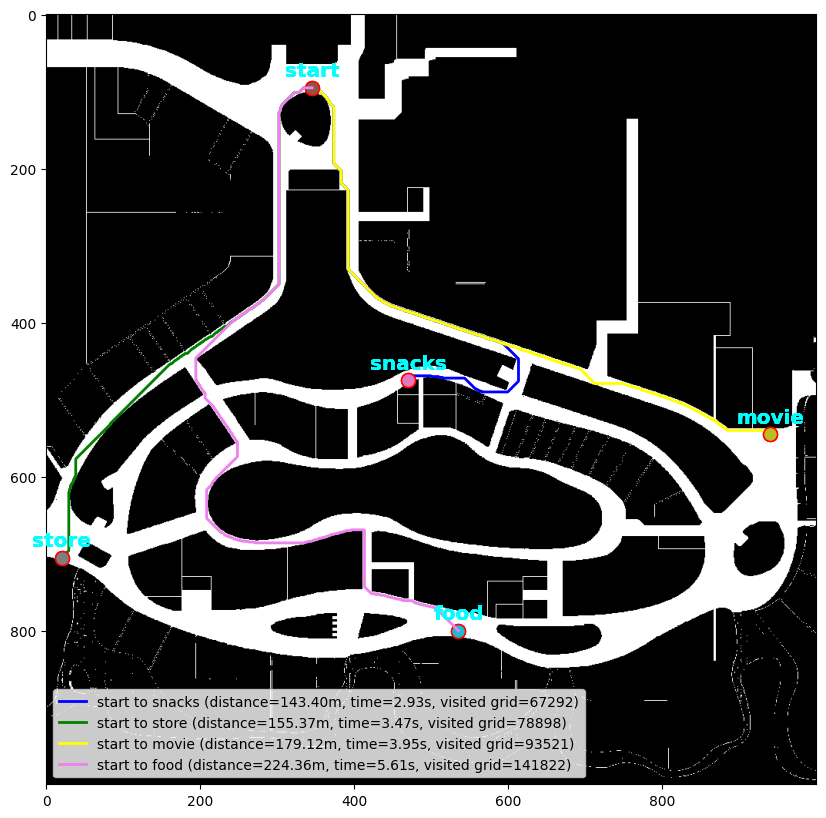

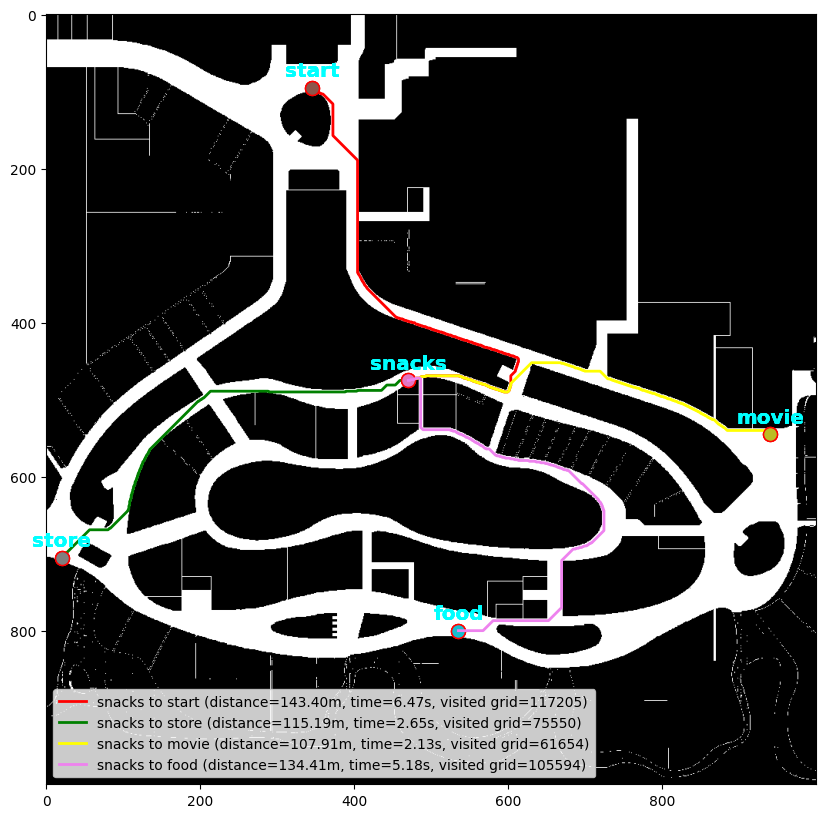

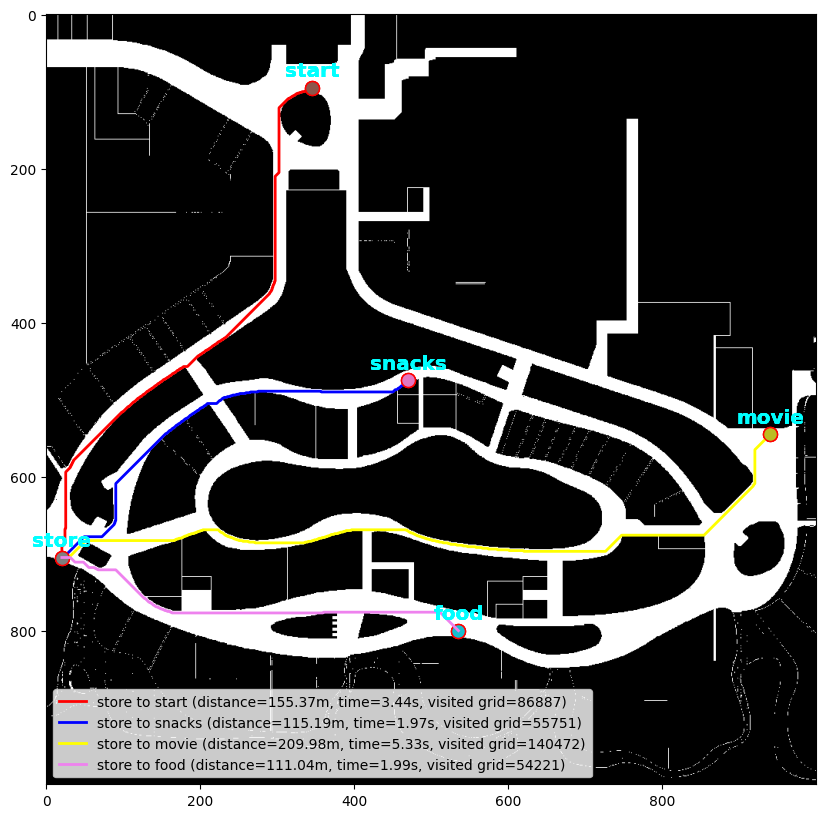

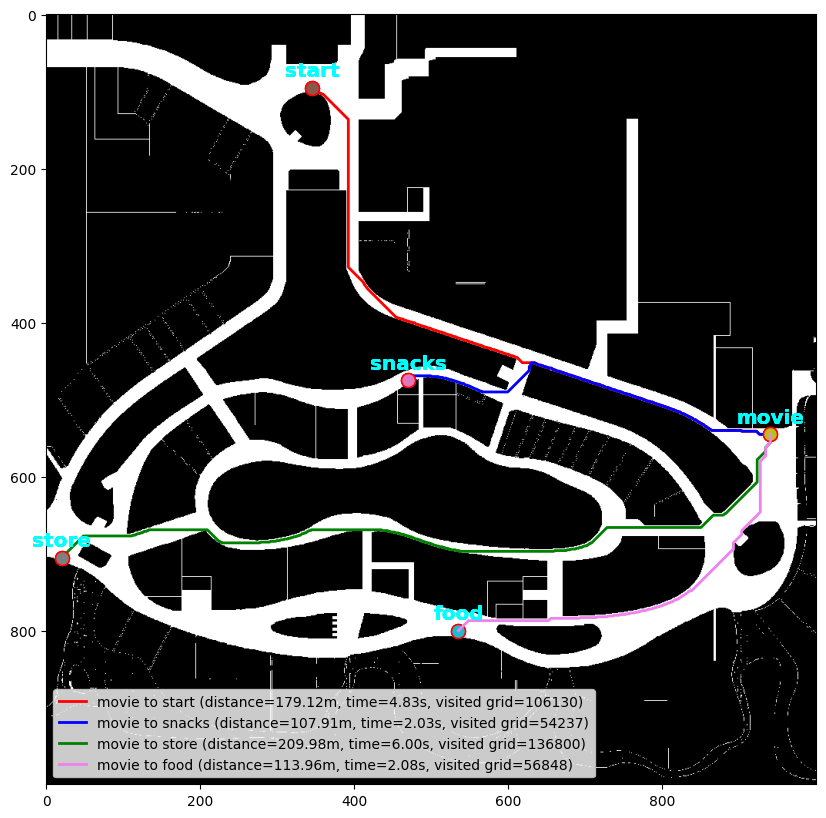

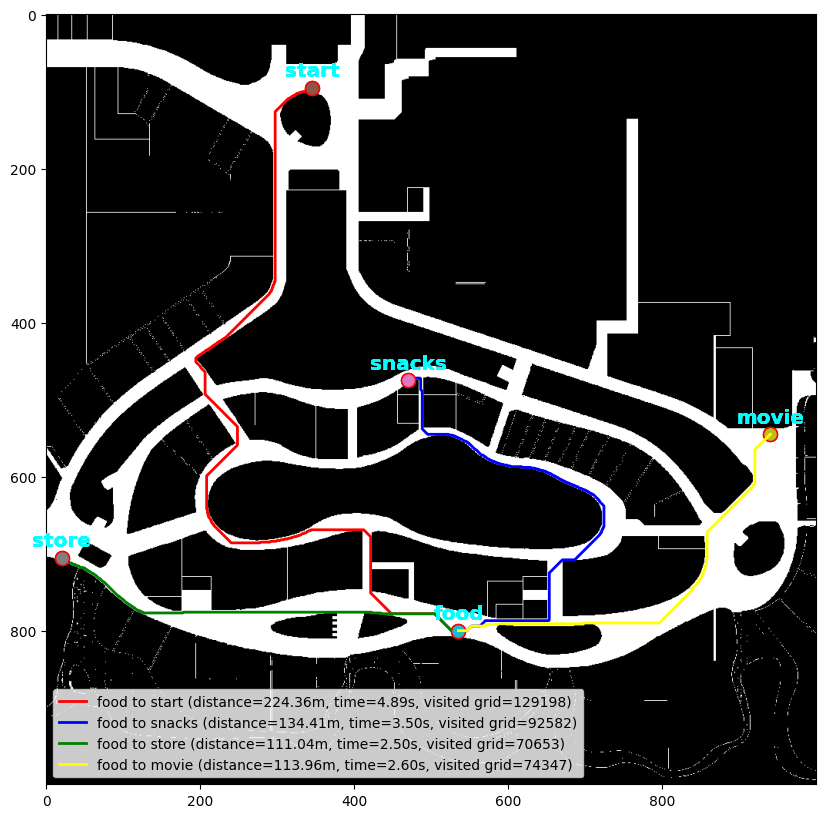

|To\From|start |snacks|store |movie |food  |
|start  |0.00  |143.40|155.37|179.12|224.36|
|snacks |143.40|0.00  |115.19|107.91|134.41|
|store  |155.37|115.19|0.00  |209.98|111.04|
|movie  |179.12|107.91|209.98|0.00  |113.96|
|food   |224.36|134.41|111.04|113.96|0.00  |


|To\From|start|snacks|store|movie|food|
|start  |0.00 |6.47  |3.44 |4.83 |4.89|
|snacks |2.93 |0.00  |1.97 |2.03 |3.50|
|store  |3.47 |2.65  |0.00 |6.00 |2.50|
|movie  |3.95 |2.13  |5.33 |0.00 |2.60|
|food   |5.61 |5.18  |1.99 |2.08 |0.00|


|To\From|start |snacks|store |movie |food  |
|start  |0     |117205|86887 |106130|129198|
|snacks |67292 |0     |55751 |54237 |92582 |
|store  |78898 |75550 |0     |136800|70653 |
|movie  |93521 |61654 |140472|0     |74347 |
|food   |141822|105594|54221 |56848 |0     |




In [8]:
# Dijkstra planner
dijkstra_planner = GraphBasedPlanner(grid_map_img, MAP_RES, AGENT_RADIUS, search_method='dijkstra')

print('Running Dijkstra planner...')
runner(dijkstra_planner)


Running greedy best-first search planner...


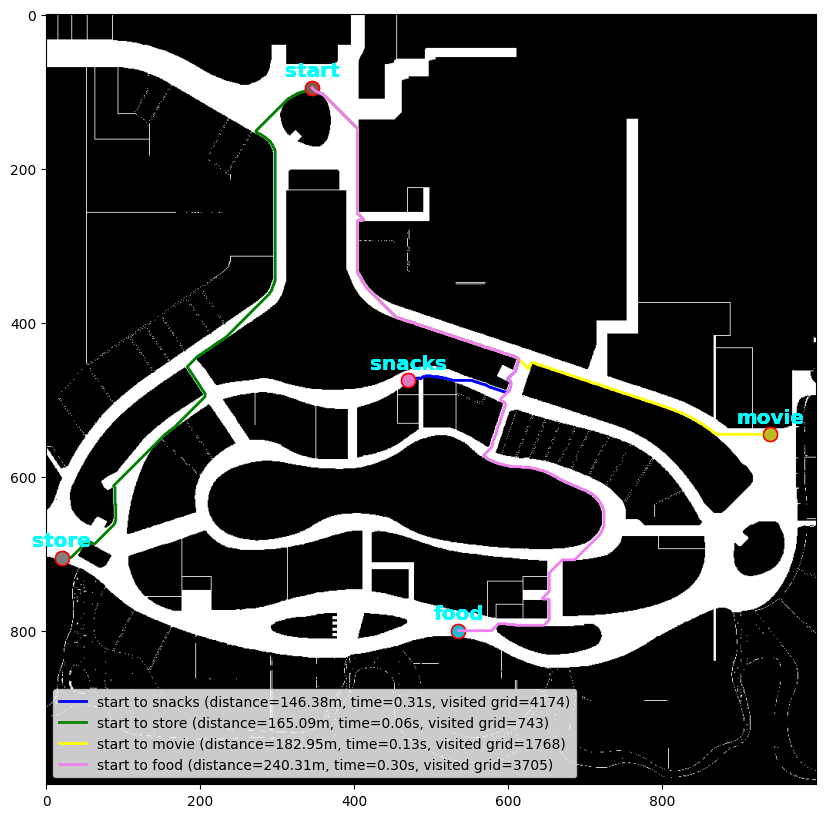

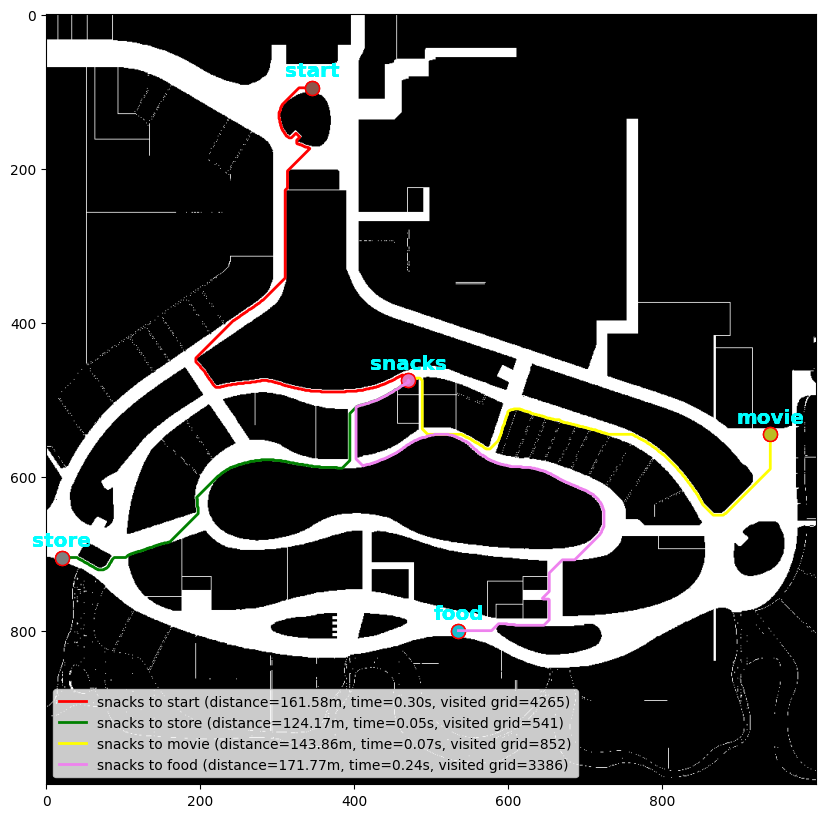

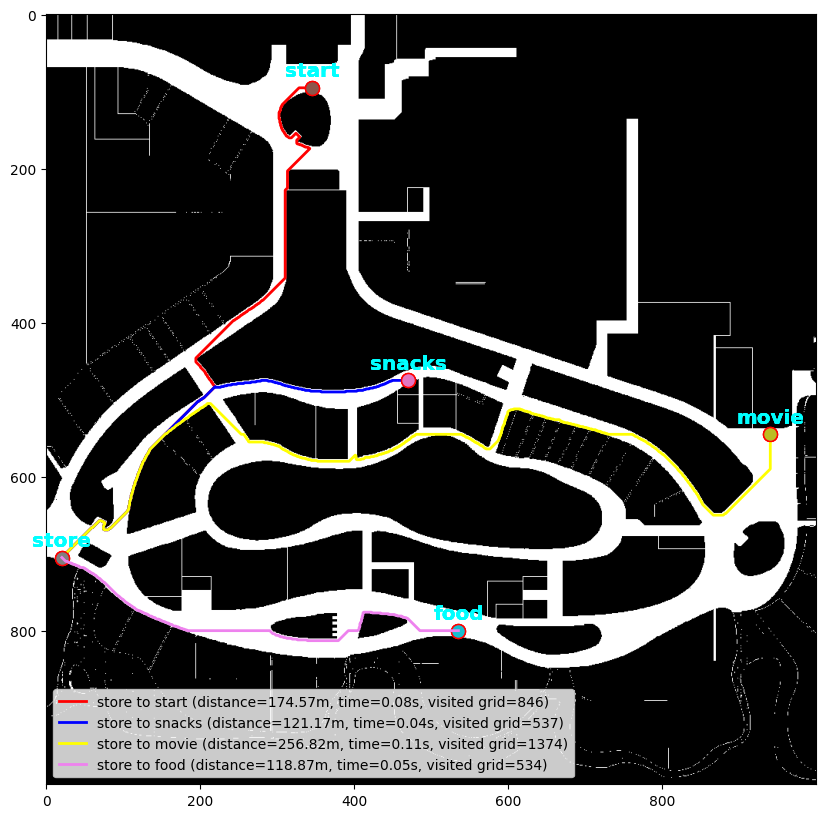

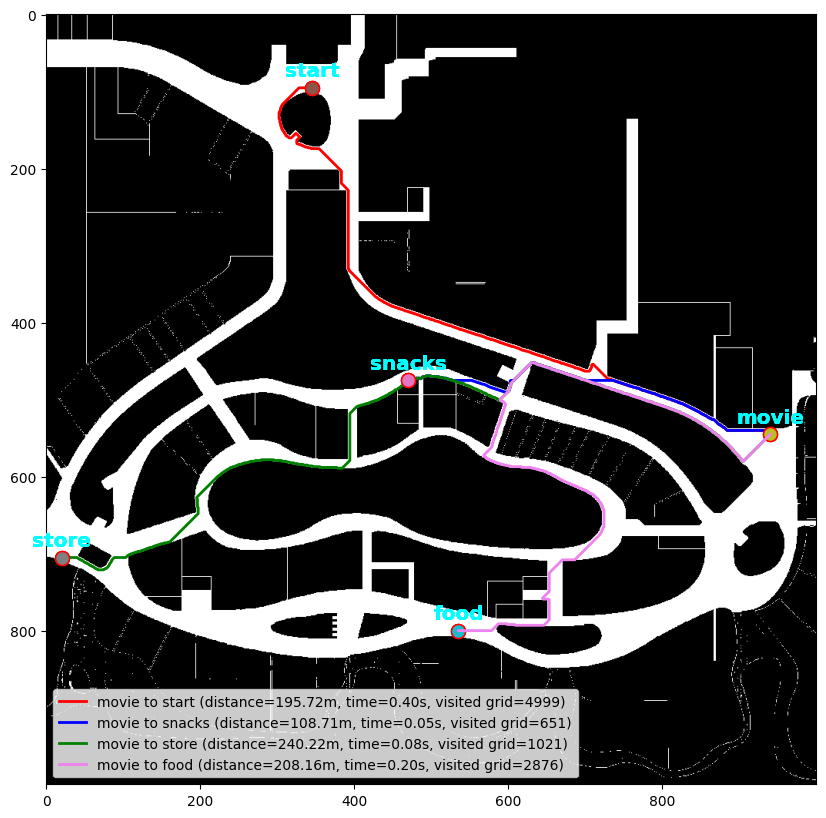

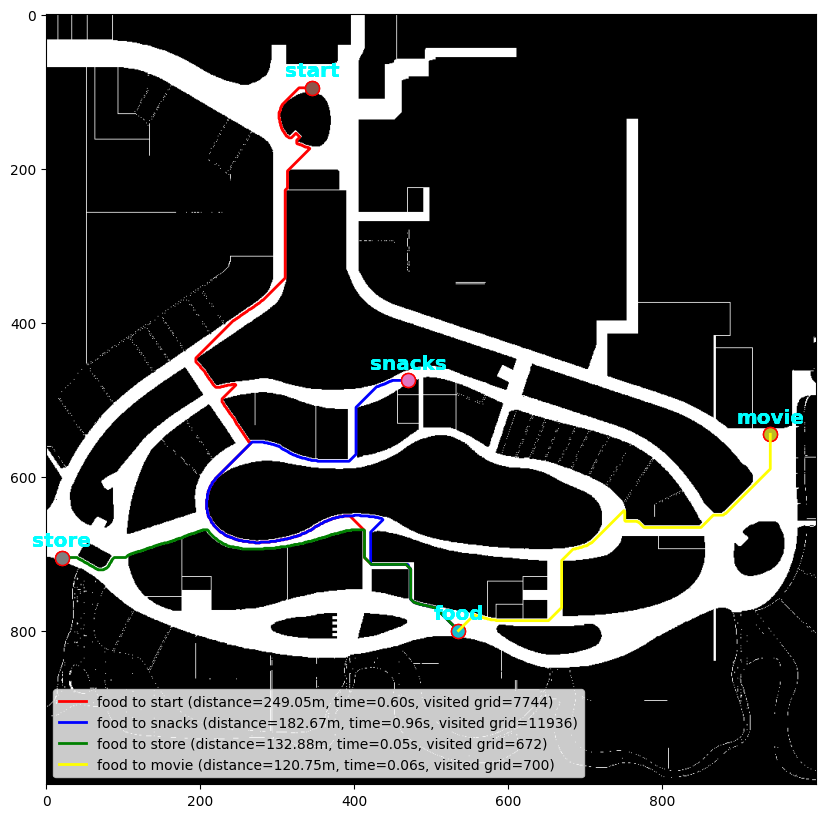

|To\From|start |snacks|store |movie |food  |
|start  |0.00  |161.58|174.57|195.72|249.05|
|snacks |146.38|0.00  |121.17|108.71|182.67|
|store  |165.09|124.17|0.00  |240.22|132.88|
|movie  |182.95|143.86|256.82|0.00  |120.75|
|food   |240.31|171.77|118.87|208.16|0.00  |


|To\From|start|snacks|store|movie|food|
|start  |0.00 |0.30  |0.08 |0.40 |0.60|
|snacks |0.31 |0.00  |0.04 |0.05 |0.96|
|store  |0.06 |0.05  |0.00 |0.08 |0.05|
|movie  |0.13 |0.07  |0.11 |0.00 |0.06|
|food   |0.30 |0.24  |0.05 |0.20 |0.00|


|To\From|start|snacks|store|movie|food |
|start  |0    |4265  |846  |4999 |7744 |
|snacks |4174 |0     |537  |651  |11936|
|store  |743  |541   |0    |1021 |672  |
|movie  |1768 |852   |1374 |0    |700  |
|food   |3705 |3386  |534  |2876 |0    |




In [9]:
# Greedy best-first search planner

gbfs_planner = GraphBasedPlanner(grid_map_img, MAP_RES, AGENT_RADIUS, search_method='gbfs', heuristic_func=euclidean)

print('Running greedy best-first search planner...')
runner(gbfs_planner)


## Task 2